# Machine Learning Zoomcamp

## Week 04: Evaluation Metrics for Classification

### Session #4 Homework

#### @Germán David Luna Puche (gdlplearning@gmail.com)

---

## Homework

> Note: sometimes your answer doesn't match one of the options exactly. That's fine. 
Select the option that's closest to your solution.


## Dataset

In this homework, we will use Credit Card Data from book "Econometric Analysis".

Here's a wget-able [link](https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AER_credit_card_data.csv):

```bash
wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AER_credit_card_data.csv
```
The goal of this homework is to inspect the output of different evaluation metrics by creating a classification model (target column `card`). 



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import DictVectorizer

from tqdm.auto import tqdm

In [2]:
df = pd.read_csv('data/AER_credit_card_data.csv')
df

,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
0,yes,0,37.66667,4.5200,0.033270,124.983300,yes,no,3,54,1,12
1,yes,0,33.25000,2.4200,0.005217,9.854167,no,no,3,34,1,13
2,yes,0,33.66667,4.5000,0.004156,15.000000,yes,no,4,58,1,5
3,yes,0,30.50000,2.5400,0.065214,137.869200,no,no,0,25,1,7
4,yes,0,32.16667,9.7867,0.067051,546.503300,yes,no,2,64,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1314,yes,0,33.58333,4.5660,0.002146,7.333333,yes,no,0,94,1,19
1315,no,5,23.91667,3.1920,0.000376,0.000000,no,no,3,12,1,5
1316,yes,0,40.58333,4.6000,0.026513,101.298300,yes,no,2,1,1,2
1317,yes,0,32.83333,3.7000,0.008999,26.996670,no,yes,0,60,1,7


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1319 entries, 0 to 1318
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   card         1319 non-null   object 
 1   reports      1319 non-null   int64  
 2   age          1319 non-null   float64
 3   income       1319 non-null   float64
 4   share        1319 non-null   float64
 5   expenditure  1319 non-null   float64
 6   owner        1319 non-null   object 
 7   selfemp      1319 non-null   object 
 8   dependents   1319 non-null   int64  
 9   months       1319 non-null   int64  
 10  majorcards   1319 non-null   int64  
 11  active       1319 non-null   int64  
dtypes: float64(4), int64(5), object(3)
memory usage: 123.8+ KB


---
## Preparation

* Create the target variable by mapping `yes` to 1 and `no` to 0. 
* Split the dataset into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` funciton for that with `random_state=1`.

In [4]:
binary_values = {'yes': 1, 'no': 0}

df['card'] = df['card'].map(binary_values)      # Create the target variable by mapping yes to 1 and no to 0
df.head()

,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
0,1,0,37.66667,4.5200,0.033270,124.983300,yes,no,3,54,1,12
1,1,0,33.25000,2.4200,0.005217,9.854167,no,no,3,34,1,13
2,1,0,33.66667,4.5000,0.004156,15.000000,yes,no,4,58,1,5
3,1,0,30.50000,2.5400,0.065214,137.869200,no,no,0,25,1,7
4,1,0,32.16667,9.7867,0.067051,546.503300,yes,no,2,64,1,5


In [5]:
df['card'].value_counts(normalize=True)      # Check the balance between classes

1    0.775588
0    0.224412
Name: card, dtype: float64

Split the dataset into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` funciton for that with `random_state=1`.

In [6]:
df_full_train, df_test = train_test_split(df, test_size = 0.2, random_state = 1)
df_train, df_val = train_test_split(df_full_train, test_size = 0.25, random_state = 1)

df_train = df_train.reset_index(drop = True)
df_val = df_val.reset_index(drop = True)
df_test = df_test.reset_index(drop = True)

y_train = df_train['card'].values
y_val = df_val['card'].values
y_test = df_test['card'].values

del df_train['card']
del df_val['card']
del df_test['card']

len(df_train), len(df_val), len(df_test)

(791, 264, 264)

---
## Question 1

ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that

* For each numerical variable, use it as score and compute AUC with the `card` variable.
* Use the training dataset for that.

If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['expenditure']`)

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

- `reports`
- `dependents`
- `active`
- **`share` *(correct answer)***


In [7]:
numerical = [col for col in df_train.columns if (df_train[col].dtype != 'object')]

categorical = [col for col in df_train.columns if (df_train[col].dtype == 'object')]

numerical, categorical

(['reports',
  'age',
  'income',
  'share',
  'expenditure',
  'dependents',
  'months',
  'majorcards',
  'active'],
 ['owner', 'selfemp'])

In [8]:
auc_scores = {}

for var in ['reports', 'dependents', 'active', 'share']:
    score = roc_auc_score(y_train, df_train[var])
    if score < 0.5:
        score = roc_auc_score(y_train, -df_train[var])
    auc_scores[var] = round(score, 4)

auc_scores    # 'share' has the highest AUC with a value of 0.989

{'reports': 0.7167, 'dependents': 0.5328, 'active': 0.6043, 'share': 0.9892}

## Training the model

From now on, use these columns only:

```
["reports", "age", "income", "share", "expenditure", "dependents", "months", "majorcards", "active", "owner", "selfemp"]
```

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```



In [9]:
features = ["reports", "age", "income", "share", "expenditure", "dependents", 
            "months", "majorcards", "active", "owner", "selfemp"]

In [10]:
dv = DictVectorizer(sparse = False)

train_dict = df_train[features].to_dict(orient = 'records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [11]:
val_dict = df_val[features].to_dict(orient = 'records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]

## Question 2

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.615
- 0.515
- 0.715
- **0.995 *(correct answer)***

In [12]:
roc_auc_score(y_val, y_pred).round(3)   # The AUC of this model on the validation dataset is 0.995

0.995

## Question 3

Now let's compute precision and recall for our model.

* Evaluate the model on the validation dataset on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them


At which threshold precision and recall curves intersect?

* 0.1
* **0.3 *(correct answer)***
* 0.6
* 0.8



In [13]:
scores = []
thresholds = np.linspace(0.0, 1.0, 101)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)
    
    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()
    
    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    accuracy = (tp + tn) / len(y_pred)
    
    scores.append((t, tp, fp, fn, tn, precision, recall, accuracy))

In [14]:
columns = ['threshold', 'tp', 'fp', 'fn', 'tn', 'precision', 'recall', 'accuracy']

df_scores = pd.DataFrame(scores, columns = columns)
df_scores[::10]

,threshold,tp,fp,fn,tn,precision,recall,accuracy
0,0.0,211,53,0,0,0.799242,1.000000,0.799242
10,0.1,210,17,1,36,0.925110,0.995261,0.931818
20,0.2,207,5,4,48,0.976415,0.981043,0.965909
30,0.3,205,5,6,48,0.976190,0.971564,0.958333
40,0.4,205,1,6,52,0.995146,0.971564,0.973485
50,0.5,204,1,7,52,0.995122,0.966825,0.969697
60,0.6,204,1,7,52,0.995122,0.966825,0.969697
70,0.7,204,1,7,52,0.995122,0.966825,0.969697
80,0.8,204,1,7,52,0.995122,0.966825,0.969697
90,0.9,204,0,7,53,1.000000,0.966825,0.973485


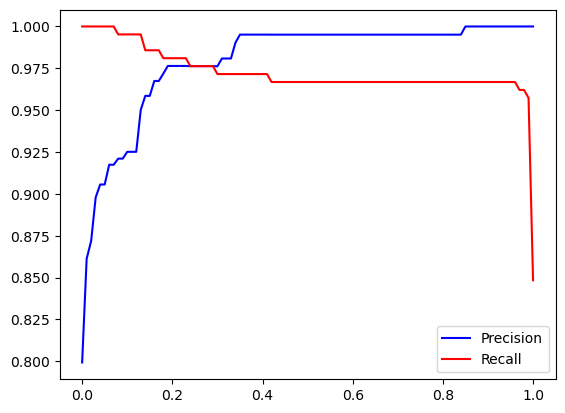

In [15]:
plt.plot(df_scores['threshold'], df_scores['precision'], 'b')
plt.plot(df_scores['threshold'], df_scores['recall'], 'r')
plt.legend(['Precision', 'Recall'])

In [16]:
df_scores['threshold'][df_scores.precision == df_scores.recall]

24    0.24
25    0.25
26    0.26
27    0.27
28    0.28
29    0.29
Name: threshold, dtype: float64

At which threshold precision and recall curves intersect?

These curves intersect at the following thresholds: ```[0.24, 0.25, 0.26, 0.27, 0.28, 0.29]```, so for the answer we choose an approximate of ```0.3```


## Question 4

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing $F_1$:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01 using the validation set

At which threshold F1 is maximal?

- 0.1
- **0.4 *(correct answer)***
- 0.6
- 0.7


In [17]:
df_scores['F1'] = 2 * ((df_scores.precision * df_scores.recall) / (df_scores.precision + df_scores.recall))

df_scores.loc[df_scores.F1 == df_scores.F1.max()]

,threshold,tp,fp,fn,tn,precision,recall,accuracy,F1
35,0.35,205,1,6,52,0.995146,0.971564,0.973485,0.983213
36,0.36,205,1,6,52,0.995146,0.971564,0.973485,0.983213
37,0.37,205,1,6,52,0.995146,0.971564,0.973485,0.983213
38,0.38,205,1,6,52,0.995146,0.971564,0.973485,0.983213
39,0.39,205,1,6,52,0.995146,0.971564,0.973485,0.983213
40,0.40,205,1,6,52,0.995146,0.971564,0.973485,0.983213
41,0.41,205,1,6,52,0.995146,0.971564,0.973485,0.983213


F1 is maximal at the following thresholds: ```[0.35, 0.36, 0.37, 0.38, 0.39, 0.40, 0.41]```, so for the answer we choose an approximate of ```0.4```

## Question 5

Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation


How large is standard devidation of the AUC scores across different folds?

- **0.003 *(correct answer)***
- 0.014
- 0.09
- 0.24


In [18]:
def train(df_train, y_train, C = 1.0):
    dicts = df_train[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [19]:
def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [20]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

In [21]:
scores = []

for train_idx, val_idx in tqdm(kfold.split(df_full_train)):
    
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]
    
    y_train = df_train.card.values
    y_val = df_val.card.values
    
    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)
    
    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)
    
print('%.3f +- %.3f' % (np.mean(scores), np.std(scores)))

0it [00:00, ?it/s]

0.996 +- 0.003


How large is standard devidation of the AUC scores across different folds?

The standard devidation of the AUC scores across different folds is ```0.003```

## Question 6

Now let's use 5-Fold cross-validation to find the best parameter C

* Iterate over the following C values: `[0.01, 0.1, 1, 10]`
* Initialize `KFold` with the same parameters as previously
* Use these parametes for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)


Which C leads to the best mean score?

- 0.01
- 0.1
- **1 *(correct answer)***
- 10

If you have ties, select the score with the lowest std. If you still have ties, select the smallest C

In [22]:
n_splits = 5

for C in tqdm([0.01, 0.1, 1, 10]):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)
    
    scores = []
    
    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]
        
        y_train = df_train.card.values
        y_val = df_val.card.values
        
        dv, model = train(df_train, y_train, C = C)
        y_pred = predict(df_val, dv, model)
        
        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

  0%|          | 0/4 [00:00<?, ?it/s]

C=0.01 0.992 +- 0.006
C=0.1 0.995 +- 0.004
C=1 0.996 +- 0.003
C=10 0.996 +- 0.003


Which C leads to the best mean score? ```C=1``` leads to the best mean score (0.996) with the lowest std (0.003) and the smallest C

## Submit the results

* Submit your results here: https://forms.gle/8TfKNRd5Jq7sGK5M9
* You can submit your solution multiple times. In this case, only the last submission will be used 
* If your answer doesn't match options exactly, select the closest one


## Deadline

The deadline for submitting is October 3 (Monday), 23:00 CEST.

After that, the form will be closed.
